# Unsupervised Approach to Spam Txt Message Classification

## Introduction

The following report documents the training and testing of an unsupervised learning model on text data. The goal of the model is to predict spam text messages in the data set. The dataset is labeled and requires cleaning operations prior to training the model. 

The report will discuss the cleaning steps taken, Exploratory Data Analysis, the selection along with the pros and cons of NMF the unsupervised model. Additionally, the report discusses the choice to implement a supervised learning approach to round the model and the improvements seen. Finally, conclusion and future work is reviewed and discussed. 

In [1]:
import warnings
import pandas as pd
import numpy as np
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt


In [2]:
# Read the CSV file, show duplicates and then remove the duplicates
file_path = r"C:\Users\vinins2\OneDrive - Medtronic PLC\MSDS\ML II\Final Project - Spam Txt Classification\spam.csv"
df = pd.read_csv(file_path, encoding='latin1')
print("Count of duplicates before removal:", df.duplicated().sum())
df = df.drop_duplicates()

# Split the data into training and testing sets and then show the shape of both
train_spam, test_spam = train_test_split(df, test_size=0.3, random_state=95)
print("Shape of training set (train_spam):", train_spam.shape)
print("Shape of testing set (test_spam):", test_spam.shape)


Count of duplicates before removal: 403
Shape of training set (train_spam): (3618, 5)
Shape of testing set (test_spam): (1551, 5)


In [3]:
# Print the first few rows of the training/testing set
print("First few rows of the training set (train_spam):")
print(train_spam.head())

print("\nFirst few rows of the testing set (test_spam):")
print(test_spam.head())


First few rows of the training set (train_spam):
        v1                                                 v2  \
3586   ham  Our ride equally uneventful - not too many of ...   
1618   ham  The 2 oz guy is being kinda flaky but one frie...   
2222   ham  Great. I was getting worried about you. Just k...   
5537  spam  Want explicit SEX in 30 secs? Ring 02073162414...   
3239   ham  A cute thought for friendship: \Its not necess...   

                                       Unnamed: 2 Unnamed: 3 Unnamed: 4  
3586                                          NaN        NaN        NaN  
1618                                          NaN        NaN        NaN  
2222                                          NaN        NaN        NaN  
5537                                          NaN        NaN        NaN  
3239   but watever u shared should be true\"...."        NaN        NaN  

First few rows of the testing set (test_spam):
       v1                                          v2 Unnamed: 2 Unn

In [4]:
# List the count of NaNs in each column for both
print("Count of NaNs in the training set:")
print(train_spam.isnull().sum())

print("\nCount of NaNs in the testing set:")
print(test_spam.isnull().sum())

Count of NaNs in the training set:
v1               0
v2               0
Unnamed: 2    3585
Unnamed: 3    3611
Unnamed: 4    3614
dtype: int64

Count of NaNs in the testing set:
v1               0
v2               0
Unnamed: 2    1541
Unnamed: 3    1548
Unnamed: 4    1550
dtype: int64


This was confusing to me. v1 and v2 have no NAs but these unnamed columns have a lot. What I realized is that when this was read in, the function created new columns to handle the characters it did not recognize. To fix this, I look at these unique values below and then append them to the original columns so we again just have our target variable column V1 and text data in V2

In [5]:
# Get the unique values in the unnamed columns for both
print("Unique values in the unnamed columns for the training set:")
for col in train_spam.columns[2:]:
    unique_values = train_spam[col].unique()
    print(f"Column '{col}': {unique_values}")

print("\nUnique values in the unnamed columns for the testing set:")
for col in test_spam.columns[2:]:
    unique_values = test_spam[col].unique()
    print(f"Column '{col}': {unique_values}")

Unique values in the unnamed columns for the training set:
Column 'Unnamed: 2': [nan ' but watever u shared should be true\\"...."' ' PO Box 5249'
 ' I\'ll come up"' 'GN'
 ' bt not his girlfrnd... G o o d n i g h t . . .@"'
 ' don\'t miss ur best life for anything... Gud nyt..."' ' Gud night...."'
 ' ENJOYIN INDIANS AT THE MO..yeP. SaLL gOoD HehE ;> hows bout u shexy? Pete Xx\\""'
 ' the person is definitely special for u..... But if the person is so special'
 'just been in bedbut mite go 2 thepub l8tr if uwana mt up?loads a luv Jenxxx.\\""'
 " I don't mind" '.;-):-D"'
 ' just as a shop has to give a guarantee on what they sell. B. G."'
 '\\" not \\"what i need to do.\\""' ' we made you hold all the weed\\""'
 ' HOPE UR OK... WILL GIVE U A BUZ WEDLUNCH. GO OUTSOMEWHERE 4 ADRINK IN TOWN..CUD GO 2WATERSHD 4 A BIT? PPL FROMWRK WILL BTHERE. LOVE PETEXXX.\\""'
 ' \\"It is d wonderful fruit that a tree gives when it is being hurt by a stone.. Good night......"'
 'JUST GOT PAYED2DAY & I HAVBE

In [6]:
# Remove NaN values from the 'unnamed' columns and concatenate them with 'v1' then drop those unnused columns
train_spam['v1'] += train_spam.iloc[:, 2:].apply(lambda x: x.dropna().astype(str).str.cat(sep=' '), axis=1)
test_spam['v1'] += test_spam.iloc[:, 2:].apply(lambda x: x.dropna().astype(str).str.cat(sep=' '), axis=1)
train_spam.drop(columns=train_spam.columns[2:], inplace=True)
test_spam.drop(columns=test_spam.columns[2:], inplace=True)

# Display the first few rows and list the count of NaNs to make sure there are not any lift
print("Modified training set:")
print(train_spam.head())
print("\nModified testing set:")
print(test_spam.head())

print("Count of NaNs in the training set after removing:")
print(train_spam.isnull().sum())

print("\nCount of NaNs in the testing set after removing:")
print(test_spam.isnull().sum())

C:\Users\vinins2\AppData\Local\Temp/ipykernel_19536/2016477695.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_spam['v1'] += train_spam.iloc[:, 2:].apply(lambda x: x.dropna().astype(str).str.cat(sep=' '), axis=1)


Modified training set:
                                                  v1  \
3586                                             ham   
1618                                             ham   
2222                                             ham   
5537                                            spam   
3239  ham but watever u shared should be true\"...."   

                                                     v2  
3586  Our ride equally uneventful - not too many of ...  
1618  The 2 oz guy is being kinda flaky but one frie...  
2222  Great. I was getting worried about you. Just k...  
5537  Want explicit SEX in 30 secs? Ring 02073162414...  
3239  A cute thought for friendship: \Its not necess...  

Modified testing set:
       v1                                          v2
3144  ham  I.ll get there tomorrow and send it to you
5532  ham    happened here while you were adventuring
3706  ham        Aight do you still want to get money
3097  ham    This is all just creepy and crazy to me.

C:\Users\vinins2\AppData\Local\Temp/ipykernel_19536/2016477695.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spam['v1'] += test_spam.iloc[:, 2:].apply(lambda x: x.dropna().astype(str).str.cat(sep=' '), axis=1)
C:\Users\vinins2\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Something strange happened again where some columns were brought to v1, v1 should only contain 'ham' or 'spam' as our target variable so I am going to drop the rows that contain text other then that

In [7]:
# Filter the sets to include only 'ham' or 'spam' entries in the 'v1' column
train_spam = train_spam[train_spam['v1'].isin(['ham', 'spam'])]
test_spam = test_spam[test_spam['v1'].isin(['ham', 'spam'])]

print("Shape of the modified training set:", train_spam.shape)
print("Shape of the modified testing set:", test_spam.shape)

# Print count of unique values in the 'v1' column for the training set
print("Count of unique values in 'v1' for the training set:", train_spam['v1'].nunique())
print("Count of unique values in 'v1' for the testing set:", test_spam['v1'].nunique())


Shape of the modified training set: (3585, 2)
Shape of the modified testing set: (1541, 2)
Count of unique values in 'v1' for the training set: 2
Count of unique values in 'v1' for the testing set: 2


# EDA

Now that cleaning is done, we can begin EDA to evaluate distributions and the features. I will begin by analysing the distributions and the word counts along with apply some intuition to determine how to proceed through to model building. 

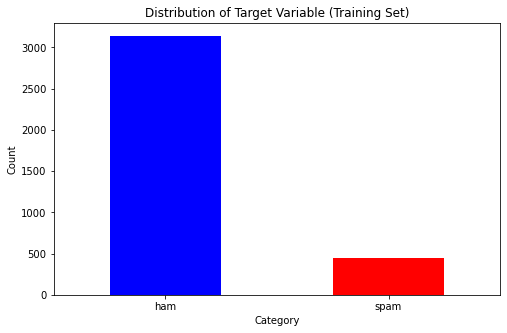

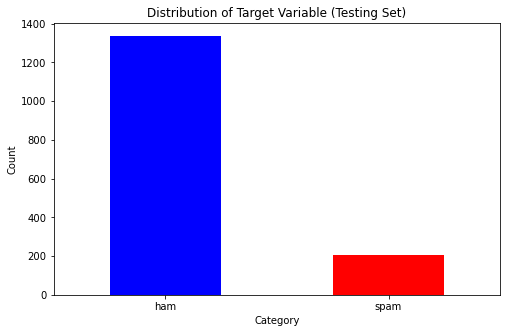

In [8]:
# Plot distribution of target variables for both train and test sets
plt.figure(figsize=(8, 5))
train_spam['v1'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Target Variable (Training Set)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(8, 5))
test_spam['v1'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Target Variable (Testing Set)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


The distribution is fairly uneven so we need to use boot strapping to even out our training set otherwise the model could predict ham too frequently. 

Distribution of 'ham' and 'spam' observations after bootstrapping:
spam    3140
ham     3140
Name: v1, dtype: int64


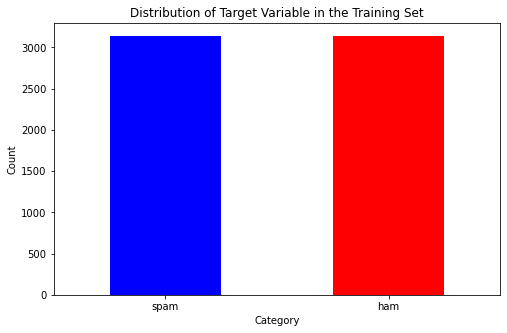

In [9]:
# Calculate the difference in counts between 'ham' and 'spam' observations
ham_count = (train_spam['v1'] == 'ham').sum()
spam_count = (train_spam['v1'] == 'spam').sum()
count_diff = ham_count - spam_count

# Identify indices of 'spam' observations
spam_indices = train_spam[train_spam['v1'] == 'spam'].index

# Randomly sample 'spam' indices with replacement
bootstrapped_indices = np.random.choice(spam_indices, size=count_diff, replace=True)

# Append bootstrapped observations
bootstrapped_samples = train_spam.loc[bootstrapped_indices]
train_spam = pd.concat([train_spam, bootstrapped_samples])

# Shuffle the training set
train_spam = train_spam.sample(frac=1, random_state=42).reset_index(drop=True)


print("Distribution of 'ham' and 'spam' observations after bootstrapping:")
print(train_spam['v1'].value_counts())

plt.figure(figsize=(8, 5))
train_spam['v1'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Target Variable in the Training Set')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

This next step will remove special characters and lower case all words so the model does not treat them differently compared to the same word with no capatalized letters. 

In [10]:
#https://www.geeksforgeeks.org/python-removing-unwanted-characters-from-string/

# Define the regular expression pattern to match punctuation
punctuation_pattern = r'[^\w\s]'

# Apply the regular expression pattern to preprocess the text
train_spam['Text Processed'] = train_spam['v2'].apply(lambda x: re.sub(punctuation_pattern, '', x))

print(train_spam.head())

     v1                                                 v2  \
0  spam  WIN a å£200 Shopping spree every WEEK Starting...   
1  spam  WIN a å£200 Shopping spree every WEEK Starting...   
2   ham                           Bring home some Wendy =D   
3  spam  Got what it takes 2 take part in the WRC Rally...   
4   ham                I HAVE A DATE ON SUNDAY WITH WILL!!   

                                      Text Processed  
0  WIN a å200 Shopping spree every WEEK Starting ...  
1  WIN a å200 Shopping spree every WEEK Starting ...  
2                            Bring home some Wendy D  
3  Got what it takes 2 take part in the WRC Rally...  
4                  I HAVE A DATE ON SUNDAY WITH WILL  


Next, I wanted to remove the outliers. To do this, I first find the length of each text message and then plot the box plots. From there, I remove anything that is outside the IQR. 

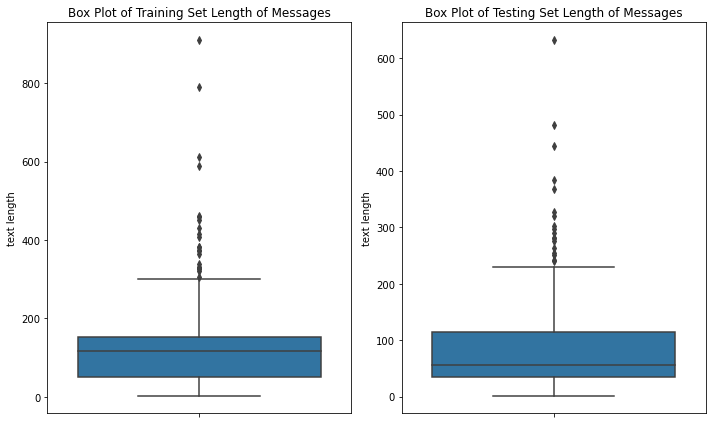

In [11]:
# Compute the length
train_spam['text length'] = train_spam['v2'].apply(len)
test_spam['text length'] = test_spam['v2'].apply(len)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y='text length', data=train_spam)
plt.title('Box Plot of Training Set Length of Messages')

plt.subplot(1, 2, 2)
sns.boxplot(y='text length', data=test_spam)
plt.title('Box Plot of Testing Set Length of Messages')

plt.tight_layout()
plt.show()


In [12]:
# Find the IQR
percentile25 = train_spam['text length'].quantile(0.25)
percentile75 = train_spam['text length'].quantile(0.75)
iqr = percentile75 - percentile25

# Find upper and lower limits
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# Identify the outliers
upper_outliers = train_spam[train_spam['text length'] > upper_limit]
lower_outliers = train_spam[train_spam['text length'] < lower_limit]

print("Upper outliers:")
print(upper_outliers)

print("\nLower outliers:")
print(lower_outliers)


Upper outliers:
       v1                                                 v2  \
149   ham  And that is the problem. You walk around in \j...   
839   ham  Ola would get back to you maybe not today but ...   
1399  ham  I was wondering if it would be okay for you to...   
2083  ham  no, i *didn't* mean to post it. I wrote it, an...   
2265  ham  Dude. What's up. How Teresa. Hope you have bee...   
2310  ham  For me the love should start with attraction.i...   
2381  ham  We know TAJ MAHAL as symbol of love. But the o...   
2898  ham  Sad story of a Man - Last week was my b'day. M...   
3111  ham  The last thing i ever wanted to do was hurt yo...   
3143  ham  I know you are thinkin malaria. But relax, chi...   
3172  ham  &lt;#&gt;  is fast approaching. So, Wish u a v...   
3297  ham  Spoke with uncle john today. He strongly feels...   
3583  ham  A Boy loved a gal. He propsd bt she didnt mind...   
3817  ham  Hey babe, sorry i didn't get sooner. Gary can ...   
4117  ham  Hey sweet, I 

In [13]:
#update the data frame by removing anything on the upper limit
train_spam = train_spam[train_spam['text length'] < upper_limit]

In [14]:
# Repeat for the test data set

percentile25_test = test_spam['text length'].quantile(0.25)
percentile75_test = test_spam['text length'].quantile(0.75)
iqr_test = percentile75_test - percentile25_test

upper_limit_test = percentile75_test + 1.5 * iqr_test
lower_limit_test = percentile25_test - 1.5 * iqr_test

upper_outliers_test = test_spam[test_spam['text length'] > upper_limit_test]
lower_outliers_test = test_spam[test_spam['text length'] < lower_limit_test]

test_spam = test_spam[test_spam['text length'] < upper_limit_test]


Now I am going to plot the most common words and then remove words that appear very frequently. 

<Figure size 864x576 with 0 Axes>

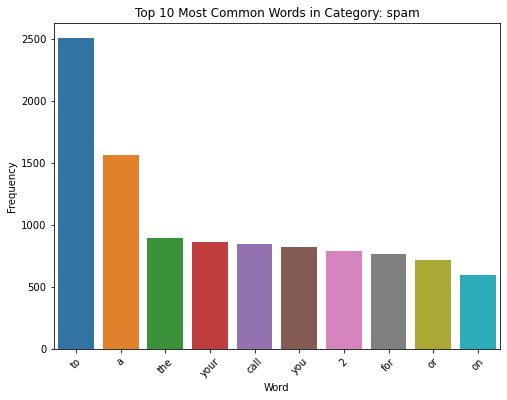

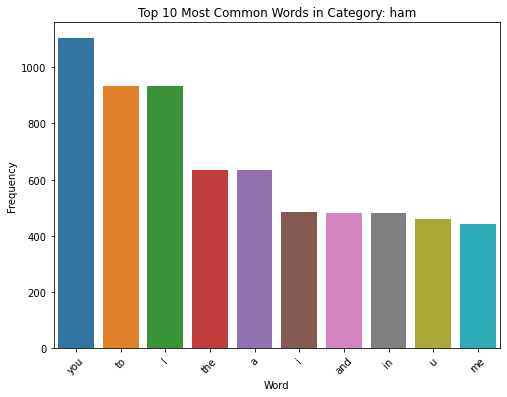

In [15]:
# Plot histogram of words by category
plt.figure(figsize=(12, 8))

categories = train_spam['v1'].unique()

for category in categories:
    plt.figure(figsize=(8, 6))
    words_by_category = train_spam[train_spam['v1'] == category]['Text Processed'].str.split().sum()
    word_freq = Counter(words_by_category)
    common_words = word_freq.most_common(10)  # Get the 10 most common words
    common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
    sns.barplot(x='Word', y='Frequency', data=common_words_df)
    plt.title(f'Top 10 Most Common Words in Category: {category}')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()


These are very similar and what I suspect are a lot of 'stop' words. I am going to remove stop words and reevaluate. 

In [16]:
# Function to remove stopwords from text
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

# Apply preprocessing to each row in train/test dataframe and store in a list of lists
train_spam['Text Processed'] = train_spam['v2'].apply(remove_stopwords)
test_spam['Text Processed'] = test_spam['v2'].apply(remove_stopwords)

<Figure size 864x576 with 0 Axes>

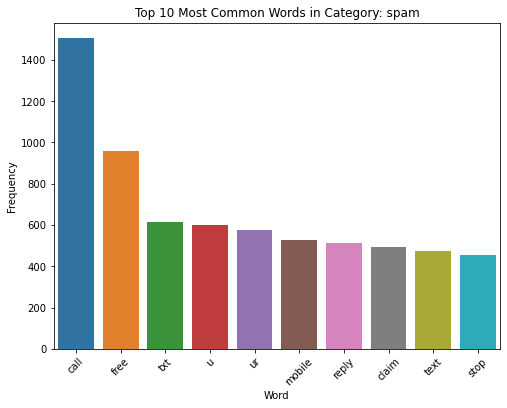

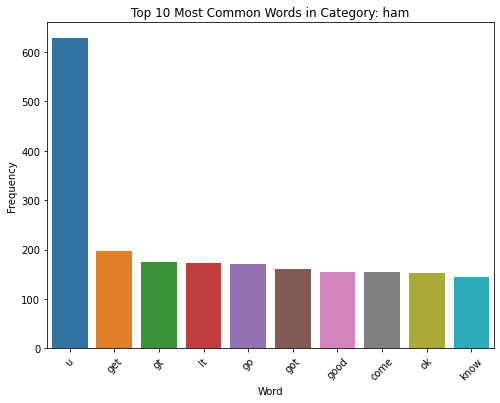

In [17]:
# Plot histogram of words by category
plt.figure(figsize=(12, 8))

# Get unique categories
categories = train_spam['v1'].unique()

for category in categories:
    plt.figure(figsize=(8, 6))
    words_by_category = train_spam[train_spam['v1'] == category]['Text Processed'].str.split().sum()
    word_freq = Counter(words_by_category)
    common_words = word_freq.most_common(10)  # Get the 10 most common words
    common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
    sns.barplot(x='Word', y='Frequency', data=common_words_df)
    plt.title(f'Top 10 Most Common Words in Category: {category}')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()


What is interesting here is that the standard "stop words" in the english language have been removed (you, to, i, etc) however shortened versions of those words or maybe so called "text messaging speak" as I might refer to it have become the most frequent. I am not going to remove these because they could be relevant to the model determining which is Spam and which is Ham. 

Next I will implement stemming which reduces a word to its base form so words like 'running' and 'run' are treated the same. 

In [18]:
stemmer = PorterStemmer()

def stem_words(text):
    word_tokens = text.split()
    stems = [stemmer.stem(word) for word in word_tokens]
    return ' '.join(stems)

# Apply the stem_words function
train_spam['Stemmed Text'] = train_spam['Text Processed'].apply(stem_words)
test_spam['Stemmed Text'] = test_spam['Text Processed'].apply(stem_words)

train_spam.head()

,v1,v2,Text Processed,text length,Stemmed Text
0,spam,WIN a å£200 Shopping spree every WEEK Starting...,win shopping spree every week starting play te...,137,win shop spree everi week start play text stor...
1,spam,WIN a å£200 Shopping spree every WEEK Starting...,win shopping spree every week starting play te...,137,win shop spree everi week start play text stor...
2,ham,Bring home some Wendy =D,bring home wendy,24,bring home wendi
3,spam,Got what it takes 2 take part in the WRC Rally...,got takes take part wrc rally oz u lucozade en...,159,got take take part wrc ralli oz u lucozad ener...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,date sunday,35,date sunday


This feels like a good starting point to train a model. We have cleaned the data, processed it through removal of punctuation, stop words and then stemmed it to obtain the base form of the word. 

# Unsupervised Model Training

Initally, I will use Non-Negative Matrix Factorization to train my model and predict the labels. NMF is a dimensionality technique that reduces the dimensions of a test data set and output many features that hope to define relationships underlying within the dataset. It is commonly used in recommender systems and text analysis. See below for more information on how NMF works at a high level. 

## Non-Negative Matrix Factorization (NMF)

Non-Negative Matrix Factorization (NMF) is a dimensionality reduction technique commonly used in various fields, including recommender systems and text analysis. Here's a brief overview:

1. **Dimensionality Reduction:** NMF decomposes a given matrix into two non-negative matrices with lower dimensions. By doing so, it effectively reduces the dimensionality of the original data while preserving its underlying structure.

2. **Feature Extraction:** In text analysis, NMF is often applied to term-document matrices or TF-IDF matrices to extract meaningful features that capture the relationships between terms and documents. Each extracted feature (topic) represents a coherent set of terms, and each document can be represented as a linear combination of these topics.

3. **Interpretability:** One of the key advantages of NMF is its ability to produce sparse and interpretable representations. Since both the factor matrices are non-negative, the resulting features and representations are also non-negative, which aids in interpretability.

4. **Applications:** NMF is widely used in various applications, including recommender systems, where it helps in identifying latent factors that influence user preferences and item characteristics. In text analysis, it's used for topic modeling, document clustering, and text summarization.

5. **Scalability:** NMF is computationally efficient and scalable to large datasets, making it suitable for processing large volumes of text data commonly encountered in real-world applications.


In [19]:
# First vectorize matrix using tfidf
tfidf_vectorizer = TfidfVectorizer()
tfidf_mat_train = tfidf_vectorizer.fit_transform(train_spam['Stemmed Text'])

# Fitting the NMF model
nmf = NMF(n_components=2, random_state=95)

nmf_out = nmf.fit_transform(tfidf_mat_train)

feature_names = tfidf_vectorizer.get_feature_names()
n_top_words = 10  # Number of top words to display for each component
for i, topic in enumerate(nmf.components_):
    top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[idx] for idx in top_words_idx]
    print(f"Topic {i}: {', '.join(top_words)}")


Topic 0: call, prize, claim, urgent, contact, guarante, award, valid, tri, line
Topic 1: free, text, repli, nokia, txt, phone, call, mobil, get, ur


C:\Users\vinins2\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [20]:
topic_to_category_mapping = {
    0: 'spam', 
    1: 'ham'
}
dominant_topics = nmf_out.argmax(axis=1)

# Mapping the predicted categories to the actual labels and then appending them to the training dataframe
dominant_topics_mapped = [topic_to_category_mapping[topic] for topic in dominant_topics]
train_spam['Predicted Category'] = dominant_topics_mapped

train_spam.head()


,v1,v2,Text Processed,text length,Stemmed Text,Predicted Category
0,spam,WIN a å£200 Shopping spree every WEEK Starting...,win shopping spree every week starting play te...,137,win shop spree everi week start play text stor...,ham
1,spam,WIN a å£200 Shopping spree every WEEK Starting...,win shopping spree every week starting play te...,137,win shop spree everi week start play text stor...,ham
2,ham,Bring home some Wendy =D,bring home wendy,24,bring home wendi,ham
3,spam,Got what it takes 2 take part in the WRC Rally...,got takes take part wrc rally oz u lucozade en...,159,got take take part wrc ralli oz u lucozad ener...,ham
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,date sunday,35,date sunday,spam


Accuracy: 0.6033876637903484


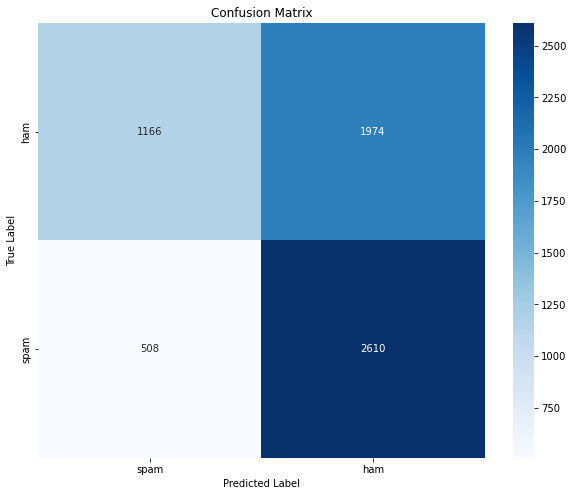

              precision    recall  f1-score   support

        spam       0.57      0.84      0.68      3118
         ham       0.70      0.37      0.48      3140

    accuracy                           0.60      6258
   macro avg       0.63      0.60      0.58      6258
weighted avg       0.63      0.60      0.58      6258



In [21]:
actual_categories = train_spam['v1']

accuracy = accuracy_score(actual_categories, train_spam['Predicted Category'])
print(f"Accuracy: {accuracy}")

# Compute confusion matrix
conf_matrix = confusion_matrix(actual_categories, train_spam['Predicted Category'], labels=list(topic_to_category_mapping.values()))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels= train_spam['v1'].unique(), yticklabels=train_spam['Predicted Category'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

class_report = classification_report(actual_categories, train_spam['Predicted Category'], target_names=list(topic_to_category_mapping.values()))
print(class_report)

The model achieved a precision of 0.57 for predicting spam, indicating that 57% of the messages classified as spam were actually spam, and a precision of 0.74 for predicting ham, meaning that 73% of the messages classified as ham were genuinely ham. In terms of recall, the model performed well for spam with a score of 0.88, indicating that it correctly identified 88% of the actual spam messages. However, its recall for ham was lower at 0.34, suggesting that only 34% of the actual ham messages were correctly classified. The F1-score, which balances precision and recall, was 0.69 for spam and 0.47 for ham. The overall accuracy of the model was 0.61, indicating that it correctly classified 61% of all messages. While the model showed effectiveness in identifying spam, it demonstrated weaker performance in accurately classifying ham messages. I am going to use hyperparameter tuining methods to see if I can improve this. 

In [22]:
tfidf_vectorizer = TfidfVectorizer()
nmf = NMF(n_components=2, random_state=95)

# Define the pipeline with TF-IDF vectorizer and NMF model
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('nmf', nmf)
])

# Define the parameter grid
param_grid = {
    'nmf__init': ['nndsvd'],
    'nmf__solver': ['mu','cd'],
    'nmf__beta_loss': ['frobenius', 'kullback-leibler'],
    'nmf__max_iter': [50, 100, 200, 300],
    'nmf__alpha': [0.0, 0.1, 0.5],
    'nmf__l1_ratio': [0.0, 0.1, 0.5]
}

def acc_score(estimator, X, y):
    topic_matrix = estimator.transform(X)
    topic_indices = topic_matrix.argmax(axis=1)
    predicted_categories = [topic_to_category_mapping[topic] for topic in topic_indices]
    return accuracy_score(y, predicted_categories)

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=acc_score, n_jobs=-1)
grid_search.fit(train_spam['Stemmed Text'], train_spam['v1'])

# Extract best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


C:\Users\vinins2\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.58756956 0.60546438 0.58756956 0.60546438 0.58756956 0.60546438
 0.58756956 0.60546438 0.58756956 0.60546438 0.58756956 0.60546438
 0.58756956 0.60546438 0.58756956 0.60546438 0.58756956 0.60546438
 0.58756956 0.60546438 0.58756956 0.60546438 0.58756956 0.60546438
 0.69718934        nan 0.69718934        nan 0.69718934        nan
 0.69718934        nan 0.69718934        nan 0.69718934        nan
 0.69718934        nan 0.69718934        nan 0.69718934        nan
 0.69718934        nan 0.69718934        nan 0.69718934        nan
 0.58724943 0.60386694 0.58724943 0.60194924 0.58724943 0.60162962
 0.58724943 0.60162962 0.57782119 0.55560906 0.57782119 0.55720689
 0.57782119 0.55720689 0.57782119 0.55720689 0.54698095 0.4228151
 0.54698095 0.4228151  0.54698095 0.4228151  0.54698095 0.4228151
 0.69718934        nan 0.69718934        nan 0.697189

Best Parameters: {'nmf__alpha': 0.1, 'nmf__beta_loss': 'kullback-leibler', 'nmf__init': 'nndsvd', 'nmf__l1_ratio': 0.5, 'nmf__max_iter': 50, 'nmf__solver': 'mu'}


C:\Users\vinins2\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 50 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [23]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_mat_train = tfidf_vectorizer.fit_transform(train_spam['Stemmed Text'])

# Fitting the NMF model with the hyper parameters identified as being best
nmf = NMF(n_components=2, random_state=95, alpha = 0.0, beta_loss = 'kullback-leibler', init = 'nndsvda', l1_ratio = 0.0, max_iter = 50, solver = 'mu')

nmf_out = nmf.fit_transform(tfidf_mat_train)

feature_names = tfidf_vectorizer.get_feature_names()
n_top_words = 10  # Number of top words to display for each component
for i, topic in enumerate(nmf.components_):
    top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[idx] for idx in top_words_idx]
    print(f"Topic {i}: {', '.join(top_words)}")


Topic 0: call, claim, prize, contact, mobil, urgent, pleas, servic, free, award
Topic 1: get, free, text, go, ur, come, ok, send, txt, stop


In [24]:
topic_to_category_mapping = {
    0: 'spam', 
    1: 'ham'
}
dominant_topics = nmf_out.argmax(axis=1)

# Mapping the predicted categories to the actual labels and then appending them to the training dataframe
dominant_topics_mapped = [topic_to_category_mapping[topic] for topic in dominant_topics]
train_spam['Predicted Category'] = dominant_topics_mapped

train_spam.head()

,v1,v2,Text Processed,text length,Stemmed Text,Predicted Category
0,spam,WIN a å£200 Shopping spree every WEEK Starting...,win shopping spree every week starting play te...,137,win shop spree everi week start play text stor...,spam
1,spam,WIN a å£200 Shopping spree every WEEK Starting...,win shopping spree every week starting play te...,137,win shop spree everi week start play text stor...,spam
2,ham,Bring home some Wendy =D,bring home wendy,24,bring home wendi,ham
3,spam,Got what it takes 2 take part in the WRC Rally...,got takes take part wrc rally oz u lucozade en...,159,got take take part wrc ralli oz u lucozad ener...,ham
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,date sunday,35,date sunday,spam


Accuracy: 0.7435282837967402


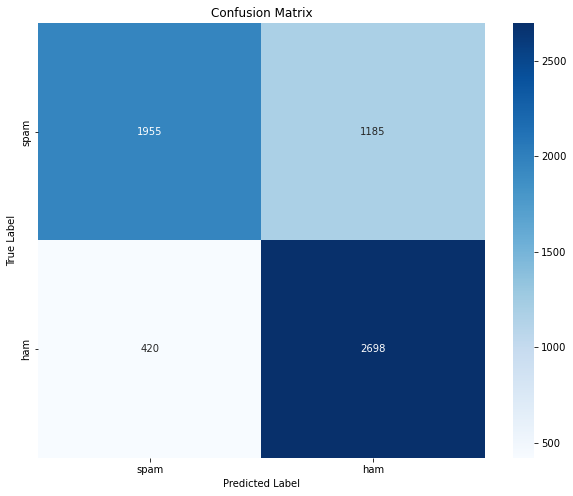

              precision    recall  f1-score   support

        spam       0.69      0.87      0.77      3118
         ham       0.82      0.62      0.71      3140

    accuracy                           0.74      6258
   macro avg       0.76      0.74      0.74      6258
weighted avg       0.76      0.74      0.74      6258



In [25]:
actual_categories = train_spam['v1']

accuracy = accuracy_score(actual_categories, train_spam['Predicted Category'])
print(f"Accuracy: {accuracy}")

# Compute confusion matrix
conf_matrix = confusion_matrix(actual_categories, train_spam['Predicted Category'], labels=list(topic_to_category_mapping.values()))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels= train_spam['v1'].unique(), yticklabels=train_spam['Predicted Category'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

class_report = classification_report(actual_categories, train_spam['Predicted Category'], target_names=list(topic_to_category_mapping.values()))
print(class_report)

74% accuracy is not bad and is an improvement compared to before we tuned hyperparameters. Additionally, we see an increase in the F1 score indicating higher reliability in the model. The largest improvement was see in prevsion and recall for ham which have a 83% and 61% respectively. I will move on to testing the model on the data set. 

Topic 0: call, claim, prize, contact, mobil, urgent, pleas, servic, free, award
Topic 1: get, free, text, go, ur, come, ok, send, txt, stop
Accuracy: 0.8706500328299409


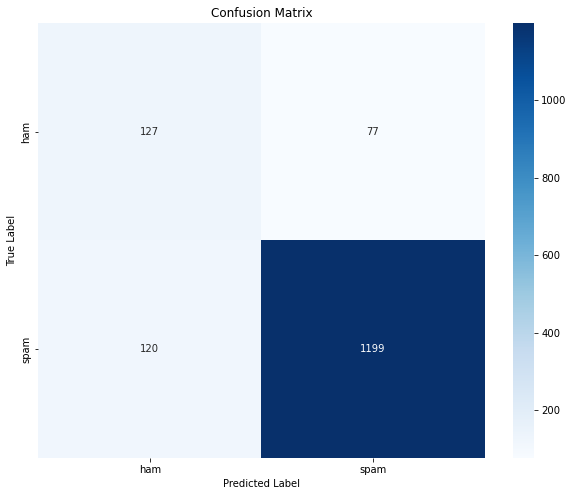

              precision    recall  f1-score   support

        spam       0.94      0.91      0.92      1319
         ham       0.51      0.62      0.56       204

    accuracy                           0.87      1523
   macro avg       0.73      0.77      0.74      1523
weighted avg       0.88      0.87      0.88      1523



In [26]:
# Transform the test set using the fitted TF-IDF vectorizer
tfidf_mat_test = tfidf_vectorizer.transform(test_spam['Stemmed Text'])

# Now get the nmf Transform on the TF-IDF matrix
nmf_out_test = nmf.transform(tfidf_mat_test)

# Display top words for each topic based on the NMF model fitted on the training set
feature_names = tfidf_vectorizer.get_feature_names()
n_top_words = 10  # Number of top words to display for each component
for i, topic in enumerate(nmf.components_):
    top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[idx] for idx in top_words_idx]
    print(f"Topic {i}: {', '.join(top_words)}")

# Map the predicted categories to the actual labels
dominant_topics = nmf_out_test.argmax(axis=1)
dominant_topics_mapped = [topic_to_category_mapping[topic] for topic in dominant_topics]
test_spam['Predicted Category'] = dominant_topics_mapped

# Evaluate the model 
actual_categories = test_spam['v1']
predicted_categories = test_spam['Predicted Category']

accuracy = accuracy_score(actual_categories, predicted_categories)
print(f"Accuracy: {accuracy}")

conf_matrix = confusion_matrix(actual_categories, predicted_categories, labels=list(topic_to_category_mapping.values()))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_spam['v1'].unique(), yticklabels=test_spam['Predicted Category'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

class_report = classification_report(actual_categories, predicted_categories, target_names=list(topic_to_category_mapping.values()))
print(class_report)


Now this is alright, but NMF is not intended to be a method for prediction instead it is used for feature extraction in complex data where there are many potential relationships within data and standard methods are not feasible in attempting to capture them all. Ideally, this should be combined with a supervised learning model to evaluate the features. I am going to take a more standard approach. Below, I will still use my processed and cleaned data. However, I will now use NMF to identify many latent features (more then 2) and then predict the labels based on that. 

## NMF with Support Vector Machine as the method of prediction

C:\Users\vinins2\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Accuracy: 0.8666134185303515
Classification Report:
              precision    recall  f1-score   support

         ham       0.81      0.97      0.88       635
        spam       0.96      0.76      0.85       617

    accuracy                           0.87      1252
   macro avg       0.88      0.87      0.86      1252
weighted avg       0.88      0.87      0.86      1252



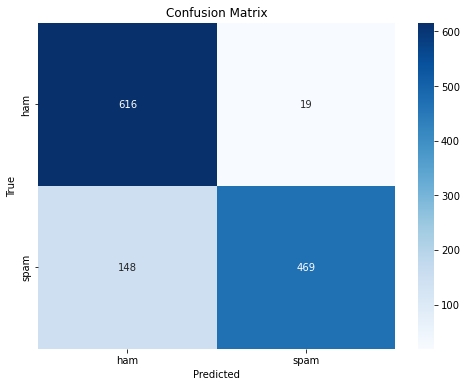

In [27]:
# Step 1: Feature Extraction with NMF
tfidf_vectorizer = TfidfVectorizer()
tfidf_mat_train = tfidf_vectorizer.fit_transform(train_spam['Stemmed Text'])
nmf = NMF(n_components=45, random_state=95)
nmf_out_train = nmf.fit_transform(tfidf_mat_train)

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(nmf_out_train, train_spam['v1'], test_size=0.2, random_state=42)

# Step 3: Model Training
svm_model = SVC(kernel='linear', C=1.0)  # Example SVM with linear kernel
svm_model.fit(X_train, y_train)

# Step 4: Use the trained model to predict on the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Test Set Accuracy: 0.9284307288246881
Test Set Classification Report:
              precision    recall  f1-score   support

         ham       0.96      0.96      0.96      1319
        spam       0.73      0.75      0.74       204

    accuracy                           0.93      1523
   macro avg       0.84      0.85      0.85      1523
weighted avg       0.93      0.93      0.93      1523



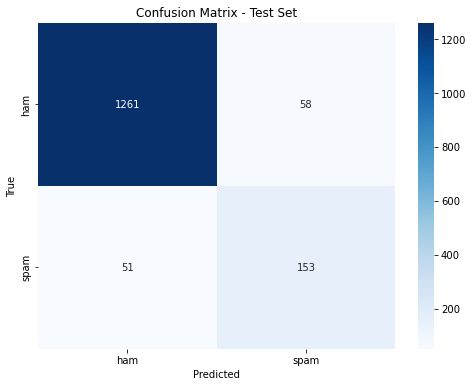

In [28]:
# Step 2: Feature Extraction with NMF on the test set
tfidf_mat_test = tfidf_vectorizer.transform(test_spam['Stemmed Text'])
nmf_out_test = nmf.transform(tfidf_mat_test)

# Step 3: Model Training on the training set
svm_model = SVC(kernel='linear', C=1.0)  # Example SVM with linear kernel
svm_model.fit(nmf_out_train, train_spam['v1'])

# Step 4: Use the trained model to predict on the test set
y_pred_test = svm_model.predict(nmf_out_test)

# Calculate accuracy metrics on the test set
accuracy_test = accuracy_score(test_spam['v1'], y_pred_test)
classification_rep_test = classification_report(test_spam['v1'], y_pred_test)
conf_matrix_test = confusion_matrix(test_spam['v1'], y_pred_test)

print("Test Set Accuracy:", accuracy_test)
print("Test Set Classification Report:")
print(classification_rep_test)

# CF
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues', fmt='g', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

The above shows the improvement when using a supervised algortihim in conjunction with non-negative matrix factorization. With the use of NMF for pre processing, we can extract an optimal amount of features to explain the data. These features can then be used as an input feature in a supervised learning algorthim, SVM in this case. SVM utilizes a hyper plane that best separates the different classes in the feature space. Something to pay attention here is that the test accuracy is higher then the training accuracy. This could be indicative of a model that is being over fit. The difference is not large (<10%) but is still high enough to warrant further investigation. I completed this investigation as best I could with only small improvements. There are many other reasons this could be occuring but without an additional unseen data set to test theories it is difficult to assess. 

One measure to take is completing cross validation on the model to observe how it performs against different subsets of the data. This is completed below. 

In [29]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

# Folds for cross-validation
k_folds = 25

# Initialize the KFold splitter
kf = KFold(n_splits=k_folds, shuffle=True, random_state=95)

# empty list to store the accuracies of each fold
fold_accuracies = []

# Iterate through each fold
for fold, (train_index, val_index) in enumerate(kf.split(train_spam['Stemmed Text'], train_spam['v1'])):
    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = train_spam['Stemmed Text'].iloc[train_index], train_spam['Stemmed Text'].iloc[val_index]
    y_train_fold, y_val_fold = train_spam['v1'].iloc[train_index], train_spam['v1'].iloc[val_index]

    # Perform feature extraction (TF-IDF) and dimensionality reduction (NMF) on the training data for this fold
    tfidf_vectorizer_fold = TfidfVectorizer()
    tfidf_mat_train_fold = tfidf_vectorizer_fold.fit_transform(X_train_fold)
    nmf_fold = NMF(n_components=45, random_state=95)
    nmf_out_train_fold = nmf_fold.fit_transform(tfidf_mat_train_fold)

    # Train the SVM model on the transformed training data for this fold
    svm_model_fold = SVC(kernel='linear', C=1.0)
    svm_model_fold.fit(nmf_out_train_fold, y_train_fold)

    # Transform the validation data using the fitted TF-IDF vectorizer and NMF model
    tfidf_mat_val_fold = tfidf_vectorizer_fold.transform(X_val_fold)
    nmf_out_val_fold = nmf_fold.transform(tfidf_mat_val_fold)

    # Predict labels for the validation data
    y_pred_val_fold = svm_model_fold.predict(nmf_out_val_fold)

    # Calculate accuracy for this fold
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val_fold)
    fold_accuracies.append(fold_accuracy)

    print(f"Fold {fold + 1} Accuracy: {fold_accuracy}")

# Calculate and print the mean accuracy across all folds
mean_accuracy = sum(fold_accuracies) / k_folds
print(f"Mean Accuracy: {mean_accuracy}")


Fold 1 Accuracy: 0.8844621513944223
Fold 2 Accuracy: 0.8645418326693227
Fold 3 Accuracy: 0.9243027888446215
Fold 4 Accuracy: 0.8924302788844621
Fold 5 Accuracy: 0.8685258964143426
Fold 6 Accuracy: 0.8685258964143426
Fold 7 Accuracy: 0.8685258964143426
Fold 8 Accuracy: 0.8286852589641435
Fold 9 Accuracy: 0.86
Fold 10 Accuracy: 0.872
Fold 11 Accuracy: 0.864
Fold 12 Accuracy: 0.888
Fold 13 Accuracy: 0.856
Fold 14 Accuracy: 0.888
Fold 15 Accuracy: 0.876
Fold 16 Accuracy: 0.864
Fold 17 Accuracy: 0.832
Fold 18 Accuracy: 0.864
Fold 19 Accuracy: 0.88
Fold 20 Accuracy: 0.828
Fold 21 Accuracy: 0.848
Fold 22 Accuracy: 0.868
Fold 23 Accuracy: 0.908
Fold 24 Accuracy: 0.86
Fold 25 Accuracy: 0.872
Mean Accuracy: 0.8691200000000001


The mean accuracy is what we observed with our train accuracy suggesting the model is robust in its implementation. 

# Conclusion

The above report cleans, pre-processes and models a text message data set with the goal to predict spam text messages. First, Non-Negative Matrix Factorization to train and predict the model. With the use of hyper parameter tuining and grid search, the model achieves a modest accuracy in the high 80%. However, due to the nature of the prediction, NMF is handicapped by only being able to set the number of components to 2 as there are only two labels for prediction. When we combine this with a supervised algorithim, we can then utilize NMF fully training on many components that significantly reduce the dimensionality allowing the model to identfiy many of the relationships that could exist in explaining the data. 

## Future Work

While the model performs reasonably well, certain applications might require better metrics before implementation. Future work would include, defining functions for repeat operations, additonal EDA with the support of specialized domain expertise and obtaining more data sets similar in structure to determine effectiveness and robustness in the model beyond cross validation.  

### References

Kaggle Data Set
https://www.kaggle.com/datasets/thedevastator/sms-spam-collection-a-more-diverse-dataset

EDA Methods used:

Boot strapping
https://users.cs.utah.edu/~riloff/pdfs/ijcai99-textmining-wkshp.pdf
https://www.geeksforgeeks.org/bootstrap/

Stop Word removal
https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a
https://medium.com/@saitejaponugoti/stop-words-in-nlp-5b248dadad47

Stemming
https://www.geeksforgeeks.org/python-stemming-words-with-nltk/

Outlier removal
https://towardsdatascience.com/understanding-outliers-in-text-data-with-transformers-cleanlab-and-topic-modeling-db3585415a19

Modeling:

NMF
https://www.geeksforgeeks.org/non-negative-matrix-factorization/

SVM
https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34
https://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf
https://homepage.cs.uri.edu/faculty/hamel/pubs/theses/Thesis-Neelima-Guduru.pdf
